# Winner-take-all threshold networks

Tse et al. 2010

## Import modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import pandas as pd
import copy

# import custom functions
from corrmat_functions import *

## Function definition

In [2]:
# ---- from denois_and_mst
#takes a correlation matrix, Q , sigma and returns the denoised and rescaled correlation matrix

def get_denoised_correlation(correlation_matrix, Q, sigma):
    eigen_values, eigen_vectors = np.linalg.eig(correlation_matrix)

    N = len(eigen_values)

    eigen_value_min = sigma**2 * (1 + 1/Q - 2 * np.sqrt(1/Q))
    eigen_value_max = sigma**2 * (1 + 1/Q + 2 * np.sqrt(1/Q))

    filtered_eigen_values = [(eigen_value_max + eigen_value_min) / 2 if x < eigen_value_max else x for x in eigen_values]
    filtered_eigen_values_norm = [x / sum(filtered_eigen_values) * N for x in filtered_eigen_values]

    Y = eigen_vectors @ np.diag(filtered_eigen_values_norm) @ np.linalg.inv(eigen_vectors)

    d = [1 / (np.sqrt(x)) for x in Y.diagonal()]
    D = np.diag(d)

    Y_rescaled = D @ Y @ D

    return Y_rescaled

# ---- from denois_and_mst
# heatmap of corr m w/ null
def print_notnull_corrmats(notnull_corrmats):
    print_corrmats({x[0]:x[1]['corrmat'] for x in notnull_corrmats.items()})

## Data Preparation

In [3]:
# load corr matrices
corrmats = load_all_corrmats() # load correlation matrices
tickers = load_corrmat_tickers() # load tickers

#loading Q values
Qs_theory = np.load('data/Qs_theory.npy', allow_pickle='TRUE').item()

# ---- from denois_and_mst
# corr matrices w/ null value
# dictionary structure :
# { <timestamp> : { 
#       'corrmat' : <correleton_matrix>,
#       'tickers' : <tickers>
#   }
# }
notnull_corrmats = {}
for key in  corrmats.keys():
    notnullcorrmat, notnullcorrmat_tickers = notnull_corrmat_and_tickers(corrmats[key], tickers)
    notnull_corrmats[key] = {'corrmat' : notnullcorrmat, 'tickers' : notnullcorrmat_tickers}
    
    

# ---- from denois_and_mst
#creating dictionary with denoised non null correlation matrices
#dictionary structure :
# { <timestamp> : { 
#       'corrmat' : <correleton_matrix>,
#       'tickers' : <tickers>
#   }
# }

denoised_notnull_corrmats = {}

for k,v in notnull_corrmats.items():
    denoised_notnull_corrmats[k] = {'corrmat': get_denoised_correlation(v['corrmat'], Qs_theory[k], 1), 'tickers': v['tickers']}

## Construction of Threshold networks

In [4]:
# generate a filtered network given a corr matrix and a threshold
def threshold_network(corr_org, threshold):
    corr = np.copy(corr_org)
    np.fill_diagonal(corr, 0) # set diagonal elements to 0, to avoid self loops
    filtered_corr = np.ma.masked_where(corr < threshold, corr).filled(fill_value=0) # filter corr matrix w/ given threshold
    g = nx.from_numpy_matrix(filtered_corr) # construct network from numpy array
    return g


# find the minimum and maximum threholds
# minimum threshold = the maximum threshold preserves the number of connected components
# maximum threhold = the largest correlation of a given corr matrix
def min_max_threshold_finder(corr_org, func = nx.number_connected_components):
    corr = np.copy(corr_org) # make a deep copy of the original corr matrix
    np.fill_diagonal(corr, 0) # set diagonal elements to 0, to avoid self loops
    benchmark_g = threshold_network(corr, 0) # construct a benchmark network w/o filtering
    
    num_connected_comp = func(benchmark_g) # number of connected components of the unfiltered network

    max_threshold = np.max(corr) # max threshold = largest corr of all pairs
    
    min_threshold = min_threshold_finder(corr, num_connected_comp, max_threshold, func = func) # calculate the min threshold, which
                                                                            # is the maximum correlation that
                                                                            # preserves a graph as connected as the original
                                                                            # w/ the same num_connected_nodes
    

    
    return min_threshold, max_threshold

# given corr matrix, max_threshold, guessed_min_threhold, find the min_thereshold by binary search
def min_threshold_finder(corr, num_connected_comp, max_threshold, min_guessed = 0, conv_limit = 0.0001, func = nx.number_connected_components):
    # base case
    if abs(max_threshold - min_guessed) < conv_limit:
        return min_guessed
    
    # recursive logic
    curr_threshold = (max_threshold + min_guessed) / 2  # take mean of given max and min as current threshold
    filtered_corr = np.ma.masked_where(corr < curr_threshold, corr).filled(fill_value=0) # filter the corr matrix by the current threshold
    g = nx.from_numpy_matrix(filtered_corr) # construct a network
    ncc_temp = func(g) # number of connected component (NCC) of current network
    g = [] # optimizer memory usage
    
    if ncc_temp > num_connected_comp: # if curr_threshold does not preserve NCC, it upper-bounds the min_threhold
        return min_threshold_finder(corr, num_connected_comp, curr_threshold, min_guessed)
    elif abs(curr_threshold - max_threshold) > conv_limit: # if curr_threshold preserves NCC, but is not accurate enough, it lower-bounds NCC
        return min_threshold_finder(corr, num_connected_comp, max_threshold, curr_threshold)
    else: # if curr_threshold preserves NCC and is accurate enough (within a neighboring interval of conv_limit)
        return curr_threshold 

In [5]:
k = list(denoised_notnull_corrmats.keys())[0]
corr = denoised_notnull_corrmats[k]['corrmat']
tic = denoised_notnull_corrmats[k]['tickers']

In [6]:
#creating dictionary of threshold networks based on denoised non null correlation matrices
#dictionary structure :
# { <timestamp> : { 
#       'thresholds' : <list_of_float_thresholds>,
#       'networks' : <list_of_threshold_networks>,
#       'tickers' : <tickers>
#   }
# }


threshold_networks = {} # instantiate a dict for threshold networks
min_max = []
thresholds_list = []
for k, v in denoised_notnull_corrmats.items():
    corr = v['corrmat']
    tics = v['tickers']
    
    # def minmax_threhold_finder(corr)
    min_threshold, max_threshold = min_max_threshold_finder(corr) # by default, to preserve the number of connected component
    min_max.append([min_threshold, max_threshold]) # keep a record of min, max thresholds
    #     min_threshold, max_threshold = min_max_threshold_finder(corr, func = lambda g: sum(np.array(g.degree)[:, 1] != 0)) # to preserve the number of nodes w/ non-zero dgr
    thresholds = np.linspace(min_threshold, max_threshold, num= 10) # generate a list of 10 thresholds
    thresholds_list.append(thresholds) # keep a record of thresholds
    
    threshold_networks[k] = {'thresholds' : thresholds,\
                                'networks' : [],\
                                'tickers' : tics}
    
    for th in thresholds:
        threshold_networks[k]['networks'].append(threshold_network(corr, th)) # store threshold network

In [7]:
#saving threshold network dictionaries to file

np.save('data/tns.npy', threshold_networks)

## Visualization of some sample threshold networks

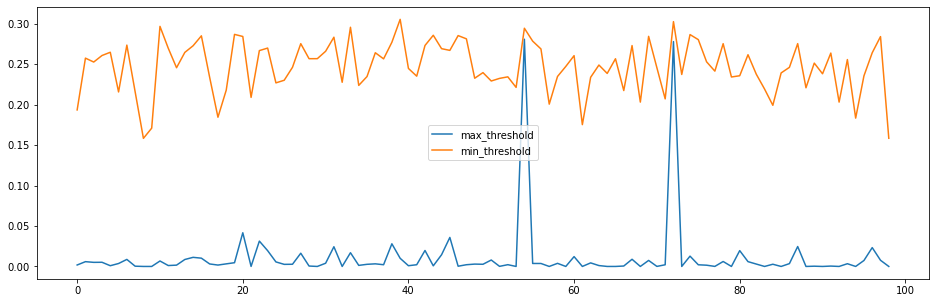

In [8]:
min_max = np.array(min_max)
fig, ax = plt.subplots(1, 1, figsize = (16, 5))
ax.plot(min_max[:, 0], label = 'max_threshold')
ax.plot(min_max[:, 1], label = 'min_threshold')
ax.legend()
# ax.set_ylim(0, 0.003)

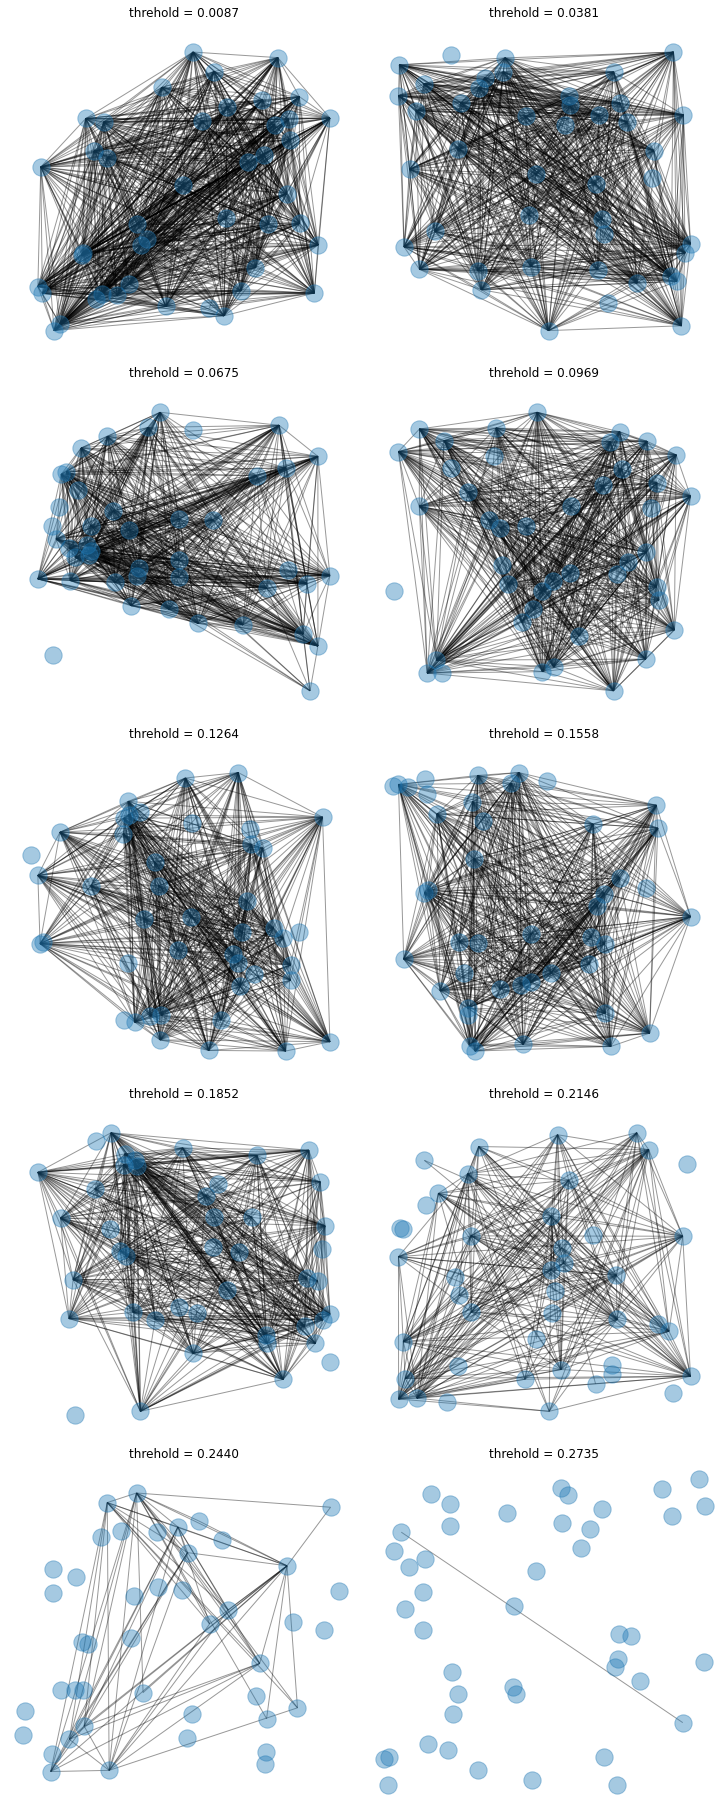

In [9]:
fig, axs = plt.subplots(5, 2, figsize = (10, 25), constrained_layout = True)
t_list = threshold_networks['2021-05-26 01-00-00']['thresholds']
g_list = threshold_networks['2021-05-26 01-00-00']['networks']
for i in range(len(g_list)):
    row = i // 2
    col = i % 2
    ax = axs[row, col]
    
    t = t_list[i]
    g = g_list[i]
    nx.draw(g, alpha = 0.4, pos = nx.random_layout(g), ax = ax)
    ax.set_title(f'threhold = {t:.4f}')